# NBA PLAYER STATS AND PREDICTION

This project focuses on predicting NBA player performance using historical data. The goal is to develop a model that can predict player performance based on various features such as past performance, team statistics, and other relevant factors. The data was sourced from publicly available NBA datasets, which include player stats, game outcomes, and other performance metrics.

### Importing Libraries

In [212]:
import pandas as pd
import requests
import numpy as np
import plotly.express as pex
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import ipywidgets as widgets
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from IPython.display import display
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

### Web Scraping from NBA Website

In this section, data was collected by scraping the NBA website. The dataset includes detailed player statistics for multiple NBA seasons, such as points scored, assists, rebounds, and field goals. Web scraping was done using Python libraries such as requests and BeautifulSoup, and the data was cleaned and formatted for analysis.

In [214]:
static_url='https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=S&Season=2022-23&SeasonType=Regular%20Season&StatCategory=PTS'

In [215]:
def web_scraping():
   
    request_header={
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language' : 'en-US,en;q=0.9',
        'Connection':'keep-alive',
        'Host':'stats.nba.com',
        'Origin':'https://www.nba.com',
        'Referer':'https://www.nba.com/',
        'Sec-Ch-Ua':'"Not A(Brand";v="99", "Microsoft Edge";v="121", "Chromium";v="121"',
        'Sec-Ch-Ua-Mobile':'?0',
        'Sec-Ch-Ua-Platform':'"Windows"',
        'Sec-Fetch-Dest':'empty',
        'Sec-Fetch-Mode':'cors',
        'Sec-Fetch-Site':'same-site',
        'User-Agent':
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0'
    }
    years = ['2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20','2020-21','2021-22','2022-23', '2023-24','2024-25']
    seasons=['Regular%20Season','Playoffs']

    df=pd.DataFrame()
    for y in years:
        for s in seasons:
            dynamic_url= 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=S&Season='+y+'&SeasonType='+s+'&StatCategory=PTS'
            response=requests.get(url = dynamic_url, headers=request_header).json()
            df1= pd.DataFrame(response['resultSet']['rowSet'], columns= response['resultSet']['headers'] )
            df2= pd.DataFrame({
                'Year':  [y for i in range(len(df1))], 
                'Season': [s for i in range(len(df1))]
            })
            df3 = pd.concat([df2,df1],axis=1)
            df = pd.concat([df, df3], axis=0)
    return df

In [216]:
data=web_scraping()

C:\Users\himas\AppData\Local\Temp\ipykernel_6592\1004075567.py:34: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



### EDA

In this section, data was collected by scraping the NBA website. The dataset includes detailed player statistics for multiple NBA seasons, such as points scored, assists, rebounds, and field goals. Web scraping was done using Python libraries such as requests and BeautifulSoup, and the data was cleaned and formatted for analysis.

In [218]:
data.head()

,Year,Season,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,2013-14,Regular%20Season,201142,1,Kevin Durant,1610612760,OKC,81,3122,849,1688,0.503,192,491,0.391,703,805,0.873,58,540,598,445,103,59,285,174,2593,2572,1.56,0.36
1,2013-14,Regular%20Season,2546,2,Carmelo Anthony,1610612752,NYK,77,2982,743,1643,0.452,167,415,0.402,459,541,0.848,145,477,622,242,95,51,198,224,2112,1942,1.22,0.48
2,2013-14,Regular%20Season,2544,3,LeBron James,1610612748,MIA,77,2902,767,1353,0.567,116,306,0.379,439,585,0.750,81,452,533,488,121,26,270,126,2089,2255,1.81,0.45
3,2013-14,Regular%20Season,201567,4,Kevin Love,1610612750,MIN,77,2797,650,1421,0.457,190,505,0.376,520,633,0.821,224,739,963,341,59,35,196,136,2010,2328,1.74,0.30
4,2013-14,Regular%20Season,201933,5,Blake Griffin,1610612746,LAC,80,2863,718,1359,0.528,12,44,0.273,482,674,0.715,192,565,757,309,92,51,224,265,1930,2082,1.38,0.41


In [219]:
data.tail()

,Year,Season,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
497,2024-25,Regular%20Season,1630556,491,Kessler Edwards,1610612742,DAL,6,10,0,2,0.0,0,2,0.0,0,0,0.0,0,0,0,0,0,0,1,2,0,-3,0.0,0.0
498,2024-25,Regular%20Season,1630644,491,Mac McClung,1610612753,ORL,1,5,0,0,0.0,0,0,0.0,0,0,0.0,0,1,1,2,0,0,0,0,0,3,0.0,0.0
499,2024-25,Regular%20Season,1630222,491,Mason Jones,1610612758,SAC,3,13,0,2,0.0,0,2,0.0,0,0,0.0,1,3,4,7,0,0,0,1,0,9,0.0,0.0
500,2024-25,Regular%20Season,1642434,491,Riley Minix,1610612759,SAS,1,7,0,1,0.0,0,1,0.0,0,0,0.0,0,2,2,0,0,0,0,0,0,1,0.0,0.0
501,2024-25,Regular%20Season,1642461,491,Spencer Jones,1610612743,DEN,2,4,0,1,0.0,0,1,0.0,0,0,0.0,0,1,1,0,2,0,0,0,0,2,0.0,0.0


In [220]:
data.shape

(8660, 30)

In [221]:
def convert_columns_to_int(columns_to_convert):
   for col in columns_to_convert:
            data[col] = data[col].astype(int)

In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8660 entries, 0 to 501
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       8660 non-null   object 
 1   Season     8660 non-null   object 
 2   PLAYER_ID  8660 non-null   object 
 3   RANK       8660 non-null   object 
 4   PLAYER     8660 non-null   object 
 5   TEAM_ID    8660 non-null   object 
 6   TEAM       8660 non-null   object 
 7   GP         8660 non-null   object 
 8   MIN        8660 non-null   object 
 9   FGM        8660 non-null   object 
 10  FGA        8660 non-null   object 
 11  FG_PCT     8660 non-null   float64
 12  FG3M       8660 non-null   object 
 13  FG3A       8660 non-null   object 
 14  FG3_PCT    8660 non-null   float64
 15  FTM        8660 non-null   object 
 16  FTA        8660 non-null   object 
 17  FT_PCT     8660 non-null   float64
 18  OREB       8660 non-null   object 
 19  DREB       8660 non-null   object 
 20  REB        866

In [223]:
data.describe(include='all')

,Year,Season,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
count,8660,8660,8660.0,8660.0,8660,8.660000e+03,8660,8660.0,8660.0,8660.0,8660.0,8660.000000,8660.0,8660.0,8660.000000,8660.0,8660.0,8660.000000,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.0,8660.00000,8660.000000
unique,12,2,1576.0,546.0,1577,3.000000e+01,30,84.0,2417.0,690.0,1247.0,NaN,273.0,594.0,NaN,440.0,532.0,NaN,285.0,608.0,750.0,559.0,164.0,175.0,291.0,273.0,1502.0,1640.0,NaN,NaN
top,2021-22,Regular%20Season,201935.0,194.0,Jae Crowder,1.610613e+09,BOS,5.0,6.0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
freq,822,6293,23.0,58.0,23,3.470000e+02,347,402.0,53.0,330.0,131.0,NaN,1778.0,927.0,NaN,891.0,804.0,NaN,809.0,277.0,225.0,567.0,907.0,1463.0,624.0,386.0,265.0,113.0,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.435400,NaN,NaN,0.276845,NaN,NaN,0.674083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60982,0.636253
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137106,NaN,NaN,0.173963,NaN,NaN,0.265268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.16893,0.565590
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.393000,NaN,NaN,0.190000,NaN,NaN,0.623000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.92000,0.330000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440000,NaN,NaN,0.327000,NaN,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.48000,0.530000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497000,NaN,NaN,0.377000,NaN,NaN,0.833000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.14000,0.820000


In [224]:
cols_to_convert= ['GP', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL','BLK','TOV','PF','PTS','EFF']
convert_columns_to_int(cols_to_convert)

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8660 entries, 0 to 501
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       8660 non-null   object 
 1   Season     8660 non-null   object 
 2   PLAYER_ID  8660 non-null   object 
 3   RANK       8660 non-null   object 
 4   PLAYER     8660 non-null   object 
 5   TEAM_ID    8660 non-null   object 
 6   TEAM       8660 non-null   object 
 7   GP         8660 non-null   int32  
 8   MIN        8660 non-null   int32  
 9   FGM        8660 non-null   int32  
 10  FGA        8660 non-null   int32  
 11  FG_PCT     8660 non-null   float64
 12  FG3M       8660 non-null   int32  
 13  FG3A       8660 non-null   int32  
 14  FG3_PCT    8660 non-null   float64
 15  FTM        8660 non-null   int32  
 16  FTA        8660 non-null   int32  
 17  FT_PCT     8660 non-null   float64
 18  OREB       8660 non-null   int32  
 19  DREB       8660 non-null   int32  
 20  REB        866

In [226]:
data.isna().sum()

Year         0
Season       0
PLAYER_ID    0
RANK         0
PLAYER       0
TEAM_ID      0
TEAM         0
GP           0
MIN          0
FGM          0
FGA          0
FG_PCT       0
FG3M         0
FG3A         0
FG3_PCT      0
FTM          0
FTA          0
FT_PCT       0
OREB         0
DREB         0
REB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
EFF          0
AST_TOV      0
STL_TOV      0
dtype: int64

In [227]:
def modify_data(dataframe):
    dataframe['Season_Start']= dataframe['Year'].str[:4].astype(int)
    dataframe.drop(columns=['RANK','TEAM_ID'], inplace= True)
    dataframe['Season'].replace('Regular%20Season', 'Regular', inplace= True)
    return dataframe

data=modify_data(data)

C:\Users\himas\AppData\Local\Temp\ipykernel_6592\3230527936.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [228]:
data.head()

,Year,Season,PLAYER_ID,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV,Season_Start
0,2013-14,Regular,201142,Kevin Durant,OKC,81,3122,849,1688,0.503,192,491,0.391,703,805,0.873,58,540,598,445,103,59,285,174,2593,2572,1.56,0.36,2013
1,2013-14,Regular,2546,Carmelo Anthony,NYK,77,2982,743,1643,0.452,167,415,0.402,459,541,0.848,145,477,622,242,95,51,198,224,2112,1942,1.22,0.48,2013
2,2013-14,Regular,2544,LeBron James,MIA,77,2902,767,1353,0.567,116,306,0.379,439,585,0.750,81,452,533,488,121,26,270,126,2089,2255,1.81,0.45,2013
3,2013-14,Regular,201567,Kevin Love,MIN,77,2797,650,1421,0.457,190,505,0.376,520,633,0.821,224,739,963,341,59,35,196,136,2010,2328,1.74,0.30,2013
4,2013-14,Regular,201933,Blake Griffin,LAC,80,2863,718,1359,0.528,12,44,0.273,482,674,0.715,192,565,757,309,92,51,224,265,1930,2082,1.38,0.41,2013


In [229]:
data.to_excel('nba_stats_data_before_cleaning.xlsx', index=False)

In [230]:
no_of_players = data['PLAYER_ID'].nunique()
no_of_teams=data.TEAM.nunique()
print('The no.of unique players: ',  no_of_players)
print('No.of Teams :', no_of_teams)

The no.of unique players:  1576
No.of Teams : 30


## Data Preprocessing

Modifications were made to the dataset to enhance its usability for analysis. A new column, Season_Start, was added, extracting the starting year of each season from the Year column. Unnecessary columns such as RANK and TEAM_ID were removed, and the 'Season' column was cleaned by replacing 'Regular%20Season' with 'Regular'. This preprocessing step ensures that the dataset is streamlined and ready for further analysis.

In [231]:
tot_cols =['MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF','PTS']

In [232]:
def group_by_playerID():
    data_per_player = data.groupby(['PLAYER','PLAYER_ID','Year'])[tot_cols].sum().reset_index()
    return data_per_player

In [233]:
data_per_player=group_by_playerID()
data_per_player.head()

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,108,22,44,0.500,10,25,0.400,2,8,0.250,6,15,21,2,2,0,3,11,56
1,A.J. Lawson,1630639,2023-24,341,58,130,0.890,15,56,0.593,16,25,1.152,15,38,53,20,10,4,14,23,147
2,AJ Green,1631260,2022-23,345,53,125,0.424,44,105,0.419,4,4,1.000,6,39,45,22,6,0,9,31,154
3,AJ Green,1631260,2023-24,681,89,212,0.798,71,180,0.590,20,22,1.895,9,64,73,32,9,4,13,58,269
4,AJ Green,1631260,2024-25,507,65,136,0.478,59,124,0.476,5,6,0.833,4,47,51,23,12,2,17,51,194


In [234]:
#Dividing all quantities by minutes played per player
for col in data_per_player.columns[4:] :
    data_per_player[col] = data_per_player[col]/data_per_player['MIN']

data_per_player

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,108,0.203704,0.407407,0.004630,0.092593,0.231481,0.003704,0.018519,0.074074,0.002315,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519
1,A.J. Lawson,1630639,2023-24,341,0.170088,0.381232,0.002610,0.043988,0.164223,0.001739,0.046921,0.073314,0.003378,0.043988,0.111437,0.155425,0.058651,0.029326,0.011730,0.041056,0.067449,0.431085
2,AJ Green,1631260,2022-23,345,0.153623,0.362319,0.001229,0.127536,0.304348,0.001214,0.011594,0.011594,0.002899,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377
3,AJ Green,1631260,2023-24,681,0.130690,0.311307,0.001172,0.104258,0.264317,0.000866,0.029369,0.032305,0.002783,0.013216,0.093979,0.107195,0.046990,0.013216,0.005874,0.019090,0.085169,0.395007
4,AJ Green,1631260,2024-25,507,0.128205,0.268245,0.000943,0.116371,0.244576,0.000939,0.009862,0.011834,0.001643,0.007890,0.092702,0.100592,0.045365,0.023669,0.003945,0.033531,0.100592,0.382643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6296,Zion Williamson,1629627,2023-24,2207,0.282737,0.495696,0.000258,0.002719,0.008156,0.000151,0.157227,0.223833,0.000318,0.055279,0.128681,0.18396,0.159493,0.034889,0.021296,0.087449,0.072043,0.725419
6297,Zion Williamson,1629627,2024-25,186,0.252688,0.559140,0.002430,0.010753,0.032258,0.001790,0.215054,0.322581,0.003586,0.086022,0.172043,0.258065,0.172043,0.021505,0.037634,0.118280,0.096774,0.731183
6298,Zoran Dragic,204054,2014-15,75,0.146667,0.400000,0.004893,0.040000,0.186667,0.002853,0.040000,0.066667,0.008000,0.066667,0.040000,0.106667,0.066667,0.026667,0.000000,0.066667,0.080000,0.373333
6299,Zylan Cheatham,1629597,2019-20,51,0.117647,0.176471,0.013078,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.058824,0.117647,0.176471,0.058824,0.019608,0.019608,0.078431,0.196078,0.235294


In [235]:
data_per_player=data_per_player[data_per_player['MIN']>=100]
data_per_player

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Lawson,1630639,2022-23,108,0.203704,0.407407,0.004630,0.092593,0.231481,0.003704,0.018519,0.074074,0.002315,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519
1,A.J. Lawson,1630639,2023-24,341,0.170088,0.381232,0.002610,0.043988,0.164223,0.001739,0.046921,0.073314,0.003378,0.043988,0.111437,0.155425,0.058651,0.029326,0.011730,0.041056,0.067449,0.431085
2,AJ Green,1631260,2022-23,345,0.153623,0.362319,0.001229,0.127536,0.304348,0.001214,0.011594,0.011594,0.002899,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377
3,AJ Green,1631260,2023-24,681,0.130690,0.311307,0.001172,0.104258,0.264317,0.000866,0.029369,0.032305,0.002783,0.013216,0.093979,0.107195,0.046990,0.013216,0.005874,0.019090,0.085169,0.395007
4,AJ Green,1631260,2024-25,507,0.128205,0.268245,0.000943,0.116371,0.244576,0.000939,0.009862,0.011834,0.001643,0.007890,0.092702,0.100592,0.045365,0.023669,0.003945,0.033531,0.100592,0.382643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,Zion Williamson,1629627,2019-20,668,0.314371,0.538922,0.000873,0.008982,0.020958,0.000642,0.170659,0.266467,0.000958,0.095808,0.128743,0.224551,0.074850,0.023952,0.013473,0.088323,0.062874,0.808383
6294,Zion Williamson,1629627,2020-21,2026,0.312932,0.511846,0.000302,0.004936,0.016782,0.000145,0.182132,0.261106,0.000345,0.082428,0.135242,0.21767,0.111550,0.028134,0.019250,0.082428,0.066634,0.812932
6295,Zion Williamson,1629627,2022-23,956,0.298117,0.490586,0.000636,0.007322,0.019874,0.000385,0.185146,0.259414,0.000747,0.060669,0.150628,0.211297,0.139121,0.033473,0.016736,0.103556,0.067992,0.788703
6296,Zion Williamson,1629627,2023-24,2207,0.282737,0.495696,0.000258,0.002719,0.008156,0.000151,0.157227,0.223833,0.000318,0.055279,0.128681,0.18396,0.159493,0.034889,0.021296,0.087449,0.072043,0.725419


In [236]:
data_per_player.shape

(5422, 22)

### Feature Engineering

Key ratios like PTS/FGA, FG3M/FGM, FTA/FGA, 3PT%, and FT% were calculated to measure scoring efficiency. A correlation matrix was used to identify features most related to True Shooting Percentage (TRU%). The top correlated features selected for prediction were FTA/FGA, PTS, FGM, FG%, and PTS/FGA. A heatmap visualization helped highlight these relationships.

In [237]:
data_per_player['FG%'] = data_per_player['FGM']/data_per_player['FGA']
data_per_player['3PT%'] = data_per_player['FG3M']/data_per_player['FG3A']
data_per_player['FT%'] = data_per_player['FTM']/data_per_player['FTA']
#proportion of a player's field goal attempts that come from three-point range compared to their total field goal attempts
data_per_player['FG3A%'] = data_per_player['FG3A']/data_per_player['FGA']
#number of points scored per field goal attempt
data_per_player['PTS/FGA'] = data_per_player['PTS']/data_per_player['FGA']
# proportion of a player's field goals made that come from three-point range compared to their total field goals made
data_per_player['FG3M/FGM'] = data_per_player['FG3M']/data_per_player['FGM']
# proportion of a player's field goal attempts that result in free throw attempts
data_per_player['FTA/FGA'] = data_per_player['FTA']/data_per_player['FGA']
#True shooting percentages
data_per_player['TRU%'] = 0.5*data_per_player['PTS']/(data_per_player['FGA']+0.475*data_per_player['FTA'])
#assist-to-turnover ratio for a player
data_per_player['AST_TOV'] = data_per_player['AST']/data_per_player['TOV']

data_per_player

C:\Users\himas\AppData\Local\Temp\ipykernel_6592\1980559105.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\himas\AppData\Local\Temp\ipykernel_6592\1980559105.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\himas\AppData\Local\Temp\ipykernel_6592\1980559105.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,PLAYER,PLAYER_ID,Year,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST_TOV
0,A.J. Lawson,1630639,2022-23,108,0.203704,0.407407,0.004630,0.092593,0.231481,0.003704,0.018519,0.074074,0.002315,0.055556,0.138889,0.194444,0.018519,0.018519,0.000000,0.027778,0.101852,0.518519,0.500000,0.400000,0.250000,0.568182,1.272727,0.454545,0.181818,0.585774,0.666667
1,A.J. Lawson,1630639,2023-24,341,0.170088,0.381232,0.002610,0.043988,0.164223,0.001739,0.046921,0.073314,0.003378,0.043988,0.111437,0.155425,0.058651,0.029326,0.011730,0.041056,0.067449,0.431085,0.446154,0.267857,0.640000,0.430769,1.130769,0.258621,0.192308,0.518062,1.428571
2,AJ Green,1631260,2022-23,345,0.153623,0.362319,0.001229,0.127536,0.304348,0.001214,0.011594,0.011594,0.002899,0.017391,0.113043,0.130435,0.063768,0.017391,0.000000,0.026087,0.089855,0.446377,0.424000,0.419048,1.000000,0.840000,1.232000,0.830189,0.032000,0.606777,2.444444
3,AJ Green,1631260,2023-24,681,0.130690,0.311307,0.001172,0.104258,0.264317,0.000866,0.029369,0.032305,0.002783,0.013216,0.093979,0.107195,0.046990,0.013216,0.005874,0.019090,0.085169,0.395007,0.419811,0.394444,0.909091,0.849057,1.268868,0.797753,0.103774,0.604630,2.461538
4,AJ Green,1631260,2024-25,507,0.128205,0.268245,0.000943,0.116371,0.244576,0.000939,0.009862,0.011834,0.001643,0.007890,0.092702,0.100592,0.045365,0.023669,0.003945,0.033531,0.100592,0.382643,0.477941,0.475806,0.833333,0.911765,1.426471,0.907692,0.044118,0.698596,1.352941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6293,Zion Williamson,1629627,2019-20,668,0.314371,0.538922,0.000873,0.008982,0.020958,0.000642,0.170659,0.266467,0.000958,0.095808,0.128743,0.224551,0.074850,0.023952,0.013473,0.088323,0.062874,0.808383,0.583333,0.428571,0.640449,0.038889,1.500000,0.028571,0.494444,0.607356,0.847458
6294,Zion Williamson,1629627,2020-21,2026,0.312932,0.511846,0.000302,0.004936,0.016782,0.000145,0.182132,0.261106,0.000345,0.082428,0.135242,0.21767,0.111550,0.028134,0.019250,0.082428,0.066634,0.812932,0.611379,0.294118,0.697543,0.032787,1.588235,0.015773,0.510125,0.639227,1.353293
6295,Zion Williamson,1629627,2022-23,956,0.298117,0.490586,0.000636,0.007322,0.019874,0.000385,0.185146,0.259414,0.000747,0.060669,0.150628,0.211297,0.139121,0.033473,0.016736,0.103556,0.067992,0.788703,0.607676,0.368421,0.713710,0.040512,1.607676,0.024561,0.528785,0.642468,1.343434
6296,Zion Williamson,1629627,2023-24,2207,0.282737,0.495696,0.000258,0.002719,0.008156,0.000151,0.157227,0.223833,0.000318,0.055279,0.128681,0.18396,0.159493,0.034889,0.021296,0.087449,0.072043,0.725419,0.570384,0.333333,0.702429,0.016453,1.463437,0.009615,0.451554,0.602491,1.823834


In [238]:
cols_for_correlation = ['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS','FG%','3PT%','FT%','FG3A%','PTS/FGA','FG3M/FGM','FTA/FGA','TRU%','AST_TOV']
correlation=data_per_player[cols_for_correlation].corr()

fig = pex.imshow(correlation)
fig.update_layout(
    height=600,  # Adjust the height as desired
    width=600    # Adjust the width as desired
)
fig.show()

In [239]:
correlation['TRU%'].sort_values()

FT_PCT     -0.184346
STL        -0.117267
FG3A%      -0.114133
FG3_PCT    -0.111401
AST_TOV    -0.095784
AST        -0.093083
FG3M/FGM   -0.062659
FG3A       -0.059319
TOV        -0.055990
FG_PCT     -0.047501
PF          0.000208
FGA         0.026971
FG3M        0.103950
FT%         0.174417
FTA         0.245778
OREB        0.249219
3PT%        0.251080
BLK         0.256114
DREB        0.262377
FTM         0.266612
REB         0.278917
FTA/FGA     0.281792
PTS         0.383527
FGM         0.389741
FG%         0.805379
PTS/FGA     0.914380
TRU%        1.000000
Name: TRU%, dtype: float64

selecting the features with highest correction. Here to predict True Shooting percentage I chose FTA/FGA, PTS, FGM, FG%, PTS/FGA

### Model Selection, Training and Evaluation

The dataset is prepared for model training using XGBoost. The data is converted into DMatrix format, and an XGBoost model is trained with specified hyperparameters such as learning rate, maximum depth, and number of estimators. The model’s performance is evaluated using regression metrics, showing an R² score of 0.879, a low Mean Squared Error (0.00044), and a low Mean Absolute Error (0.01599), indicating good predictive accuracy. A warning regarding unused parameters is also noted.

In [241]:
features=['PTS','FGM','FG%','PTS/FGA']

In [242]:
X=data_per_player[features]
Y=data_per_player['TRU%']

In [243]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y, test_size=0.3, random_state=42)

In [244]:
dtotal=xgb.DMatrix(X,label=Y)
dtrain=xgb.DMatrix(xtrain,label=ytrain)
dtest=xgb.DMatrix(xtest,label=ytest)

In [245]:


def training_model(learning_rate, max_depth,n_estimators, subsample,child_weight):
    params={
    'objective':'reg:squarederror',
    'learning_rate': learning_rate,
    'max_depth' :max_depth,
    'n_estimators':n_estimators,
    'eval_metrics':'rmse',
    'subsample': subsample,
    'min_child_weight': child_weight
    }
    model=xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtest,'test')],
    )
    return model

model = training_model(learning_rate=0.1, max_depth=6,n_estimators=100, subsample=0.9,child_weight=1)

ypred=model.predict(dtest)

def calculate_metrics(y_pred,y_test):

    print(f'R2 score:, {r2_score(y_test, y_pred)}')
    print(f'Mean Squared Error:, {mean_squared_error(y_test, y_pred)}')
    print(f'Mean Absolute Error:, {mean_absolute_error(y_test, y_pred)}')

calcualte_metrics(ypred,ytest)
    

[0]	test-rmse:0.05518
[1]	test-rmse:0.05063
[2]	test-rmse:0.04661
[3]	test-rmse:0.04299
[4]	test-rmse:0.03984
[5]	test-rmse:0.03704
[6]	test-rmse:0.03463
[7]	test-rmse:0.03251
[8]	test-rmse:0.03065
[9]	test-rmse:0.02911
[10]	test-rmse:0.02777
[11]	test-rmse:0.02659
[12]	test-rmse:0.02558
[13]	test-rmse:0.02477
[14]	test-rmse:0.02409
[15]	test-rmse:0.02352
[16]	test-rmse:0.02302
[17]	test-rmse:0.02261
[18]	test-rmse:0.02229
[19]	test-rmse:0.02203
[20]	test-rmse:0.02182
[21]	test-rmse:0.02164
[22]	test-rmse:0.02148


D:\Hima\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics", "n_estimators" } are not used.




[23]	test-rmse:0.02135
[24]	test-rmse:0.02123
[25]	test-rmse:0.02117
[26]	test-rmse:0.02111
[27]	test-rmse:0.02104
[28]	test-rmse:0.02101
[29]	test-rmse:0.02098
[30]	test-rmse:0.02095
[31]	test-rmse:0.02092
[32]	test-rmse:0.02091
[33]	test-rmse:0.02090
[34]	test-rmse:0.02087
[35]	test-rmse:0.02087
[36]	test-rmse:0.02087
[37]	test-rmse:0.02085
[38]	test-rmse:0.02085
[39]	test-rmse:0.02087
[40]	test-rmse:0.02087
[41]	test-rmse:0.02087
[42]	test-rmse:0.02087
[43]	test-rmse:0.02091
[44]	test-rmse:0.02091
[45]	test-rmse:0.02091
[46]	test-rmse:0.02093
[47]	test-rmse:0.02094
[48]	test-rmse:0.02095
R2 score:, 0.8790051011790209
Mean Squared Error:, 0.000438746566310453
Mean Absolute Error:, 0.0159928505555858


#### HyperParameter Tuning

Hyperparameter tuning is not explicitly performed, but a prediction model is built using the selected features. The XGBoost model is trained with hyperparameters like learning rate, max depth, n_estimators, subsample, and min_child_weight. The function training_model() trains the model with these parameters, and it uses early stopping based on RMSE (Root Mean Squared Error) to optimize the model’s performance.

The model parameters are set to control the complexity and fitting of the model, such as the depth of trees and the learning rate, to minimize error and improve the generalization of predictions.

In [342]:
xgb_regressor = XGBRegressor()

param_grid = {
     'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_search.fit(xtrain, ytrain)

print("Best Parameters:", grid_search.best_params_)

Fitting 4 folds for each of 243 candidates, totalling 972 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


D:\Hima\Anaconda\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



In [298]:
model=training_model(learning_rate=0.1, max_depth=3,n_estimators=100, subsample=0.8,child_weight=1)
y_predict=model.predict(dtest)
calculate_metrics(y_predict,ytest)

[0]	test-rmse:0.05535
[1]	test-rmse:0.05095
[2]	test-rmse:0.04702
[3]	test-rmse:0.04359
[4]	test-rmse:0.04060
[5]	test-rmse:0.03789
[6]	test-rmse:0.03562
[7]	test-rmse:0.03354
[8]	test-rmse:0.03173
[9]	test-rmse:0.03020
[10]	test-rmse:0.02888
[11]	test-rmse:0.02770
[12]	test-rmse:0.02670
[13]	test-rmse:0.02586
[14]	test-rmse:0.02514
[15]	test-rmse:0.02450
[16]	test-rmse:0.02399
[17]	test-rmse:0.02354
[18]	test-rmse:0.02314
[19]	test-rmse:0.02283
[20]	test-rmse:0.02256
[21]	test-rmse:0.02233
[22]	test-rmse:0.02210
[23]	test-rmse:0.02190
[24]	test-rmse:0.02178
[25]	test-rmse:0.02165
[26]	test-rmse:0.02156
[27]	test-rmse:0.02147
[28]	test-rmse:0.02138
[29]	test-rmse:0.02132
[30]	test-rmse:0.02123
[31]	test-rmse:0.02118
[32]	test-rmse:0.02112
[33]	test-rmse:0.02110
[34]	test-rmse:0.02107
[35]	test-rmse:0.02106
[36]	test-rmse:0.02105
[37]	test-rmse:0.02101
[38]	test-rmse:0.02101
[39]	test-rmse:0.02098
[40]	test-rmse:0.02097
[41]	test-rmse:0.02094
[42]	test-rmse:0.02093
[43]	test-rmse:0.0209

D:\Hima\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metrics", "n_estimators" } are not used.




[62]	test-rmse:0.02083
[63]	test-rmse:0.02082
[64]	test-rmse:0.02081
[65]	test-rmse:0.02081
[66]	test-rmse:0.02081
[67]	test-rmse:0.02080
[68]	test-rmse:0.02081
[69]	test-rmse:0.02081
[70]	test-rmse:0.02082
[71]	test-rmse:0.02082
[72]	test-rmse:0.02083
[73]	test-rmse:0.02084
[74]	test-rmse:0.02084
[75]	test-rmse:0.02082
[76]	test-rmse:0.02082
[77]	test-rmse:0.02083
R2 score:, 0.8803373476439448
Mean Squared Error:, 0.00043391563072837144
Mean Absolute Error:, 0.015996006197671928


### Evaluating Results

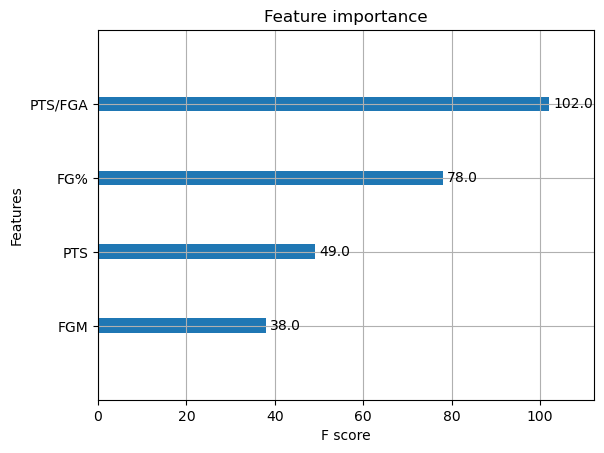

In [248]:
xgb.plot_importance(model)
plt.show()

In [300]:
residuals = ytest - y_predict

# Create an error matrix
error_matrix = np.column_stack((ytest, y_predict, residuals))

# Print the error matrix
print("Error Matrix:")
print(error_matrix)

Error Matrix:
[[ 0.56306208  0.53010517  0.03295691]
 [ 0.51880352  0.52403092 -0.0052274 ]
 [ 0.56630639  0.53510797  0.03119842]
 ...
 [ 0.58979652  0.54323012  0.0465664 ]
 [ 0.56559195  0.56653094 -0.000939  ]
 [ 0.57951018  0.58148235 -0.00197217]]


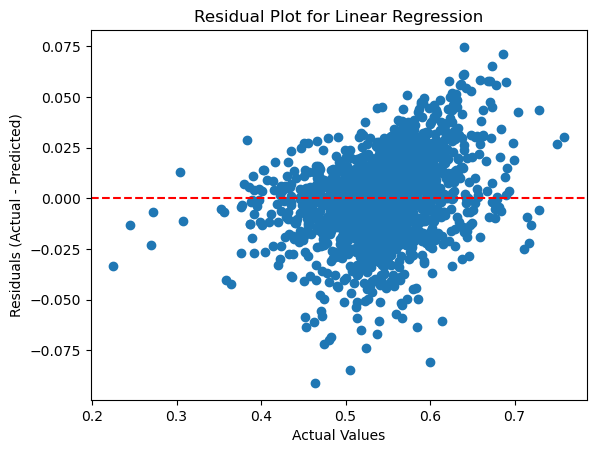

In [302]:
plt.scatter(ytest, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at y=0
plt.xlabel("Actual Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Linear Regression")
plt.show()

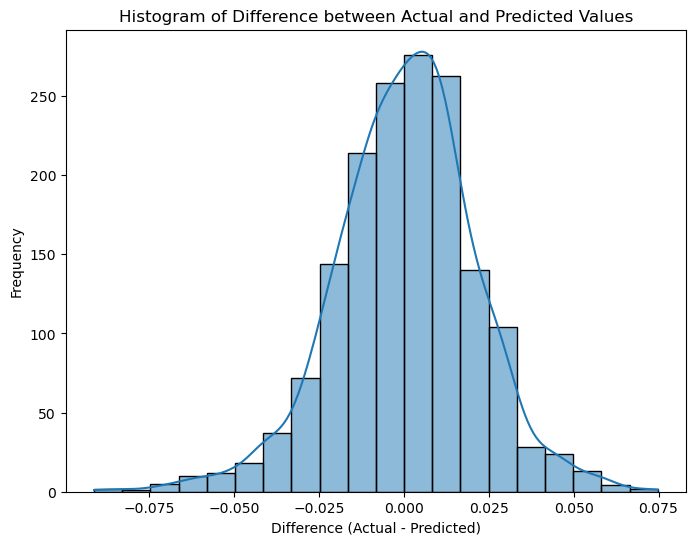

In [304]:
difference = ytest - y_predict
plt.figure(figsize=(8, 6))
sns.histplot(difference, bins=20, kde=True)
plt.xlabel('Difference (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Actual and Predicted Values')
plt.show()

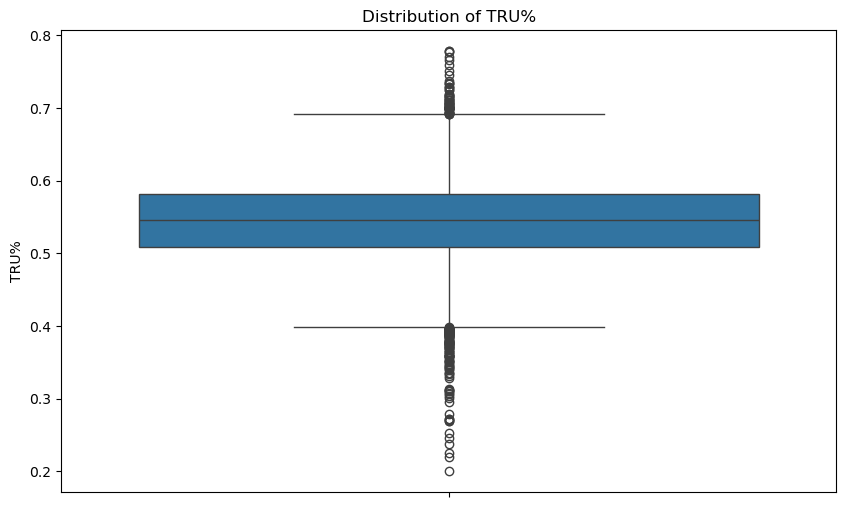

In [306]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='TRU%', data=data_per_player)
plt.ylabel('TRU%')
plt.title('Distribution of TRU%')
plt.show()

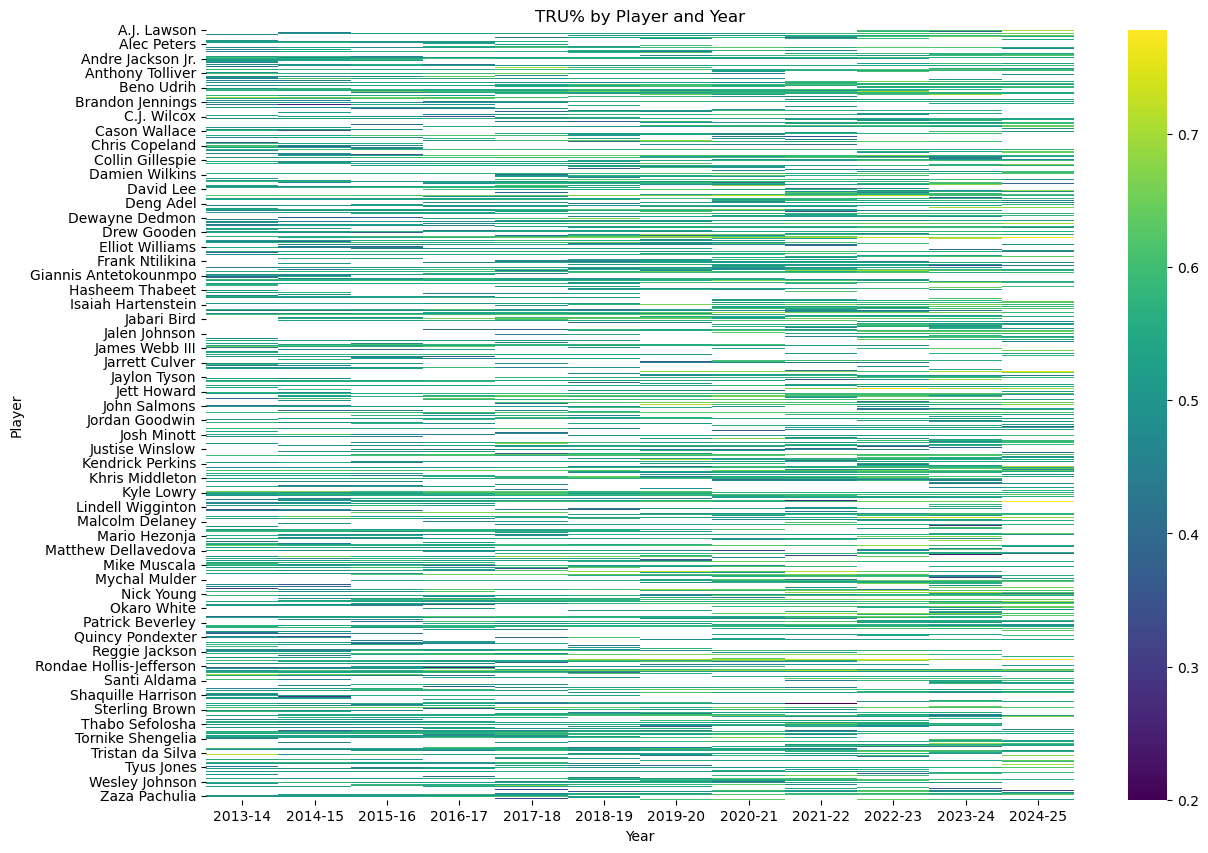

In [308]:
plt.figure(figsize=(14, 10))
sns.heatmap(data_per_player.pivot_table(index='PLAYER', columns='Year', values='TRU%'), cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Player')
plt.title('TRU% by Player and Year')
plt.show()

In [330]:
import numpy as np
import ipywidgets as widgets

# Create dropdown widget for player selection
player_dropdown = widgets.Dropdown(
    options=data_per_player['PLAYER'].unique(),
    description='Select Player:'
)

# Define function to predict TRU% for next year for selected player
def predict_next_year_tru_percentage(selected_player):
    # Subset data for the selected player
    player_data = data_per_player[data_per_player['PLAYER'] == selected_player]
    
    # Extract features for the last available year
    last_year_data = player_data.iloc[-1]  # Assuming the last row is the latest year
    features = last_year_data[['PTS/FGA', 'FG%', 'FGM', 'PTS']].values.reshape(1, -1)  # Reshaping for prediction
    
    # Use the model to predict TRU% for the next year
    next_year_tru_percentage = model.predict(dtotal)
    
    if isinstance(next_year_tru_percentage, np.ndarray):
        if next_year_tru_percentage.shape[0] == 1:
            next_year_tru_percentage = next_year_tru_percentage.item()  # Extract scalar value if it's a single prediction
        else:
            # If multiple predictions are returned, you can handle them accordingly
            print("Multiple predictions returned. Choose an appropriate approach.")
            next_year_tru_percentage = next_year_tru_percentage[0]
    
    # Print predicted TRU% for the next year
    print(f'Predicted TRU% for next year for {selected_player}: {next_year_tru_percentage:.2f}')
    
    # Provide evaluation based on TRU% prediction
    if next_year_tru_percentage > 0.65:
        print("Exceptional player with scoring efficiency")
    elif next_year_tru_percentage > 0.6:
        print("Good shooting efficiency") 
    elif next_year_tru_percentage > 0.55:
        print("Above average shooter")
    elif next_year_tru_percentage > 0.5:
        print("Average shooting efficiency")
    else:
        print("Below average shooting efficiency")

# Connect dropdown widget to the function
output = widgets.interactive_output(predict_next_year_tru_percentage, {'selected_player': player_dropdown})

# Display both the dropdown widget and the output
display(player_dropdown, output)


Dropdown(description='Select Player:', options=('A.J. Lawson', 'AJ Green', 'AJ Griffin', 'AJ Hammons', 'AJ Pri…

Output()